In [190]:
from binance.spot import Spot
client = Spot(base_url ='https://api2.binance.com')
import pandas as pd
from datetime import datetime as dt
from math import ceil

In [191]:
batch_number = 6

In [192]:
#%cd ..

In [193]:
pumps_df = pd.read_csv('data/pump_events/sample_batch{}_pump_events.csv'.format(batch_number))

In [194]:
binance_pumps = pumps_df.loc[pumps_df.exchange =='binance'].copy()
binance_pumps.loc[:,'datetime'] = pd.to_datetime([
    dtstring[:-6]
    for dtstring in binance_pumps.datetime
])
from datetime import timezone
binance_pumps.loc[:,'tz_utc'] = [
    dt_value.replace(tzinfo=timezone.utc).timestamp()
    for dt_value in binance_pumps.datetime
]

In [195]:
binance_pumps

,exchange,datetime,coin,batch,found_pump_msg_id,tz_utc
0,binance,2021-10-31 17:00:05,ez,6,4354,1.635700e+09
1,binance,2021-11-07 17:00:04,mth,6,5985,1.636304e+09
2,binance,2021-11-28 17:00:05,phb,6,5965,1.638119e+09
3,binance,2021-10-24 17:00:07,evx,6,6022,1.635095e+09
5,binance,2022-01-02 17:00:07,nebl,6,4230,1.641143e+09


In [196]:
# set input parameters
# pairing_list = [INPT]
end_date = dt.now()
timeframe_d = 365

In [197]:
# col names
cols = [
    'open_time',
    'open',
    'high',
    'low',
    'close',
    'volume',
    'close_time',
    'quote_asset_volume',
    'n_trades',
    'taker_buy_base_asset_volume',
    'taker_buy_quote_asset_volume',
    'ignore'
]

In [198]:
def get_endtimes(range_d, final_datetime):
    calls_n = ceil(range_d*24*60/1000)
    # convert final datetime to unix timestamp
    final_datetime= final_datetime.replace(second=0, microsecond=0)
    final_ts = int(dt.timestamp(final_datetime)*1000)
    # create anchor values
    anchors = range(-calls_n,1)
    # turn anchor values into timestamps for the api call
    call_times = [
        60*1000*1000*anchor + final_ts
        for anchor in anchors
    ]
    return call_times

In [199]:
def klines_call(pairing,end):
    data=client.klines(symbol=pairing,interval='1m',limit=1000,endTime=end)
    df = pd.DataFrame(data=data)
    return df

In [200]:
def get_pairing_data(pairing,range_d,final_datetime='now'):
    if final_datetime == 'now':
        end = dt.now()
    else:
        end = final_datetime
    endtimes_list = get_endtimes(range_d,end)
    df_list = [
        klines_call(pairing,time)
        for time in endtimes_list
    ]
    df = pd.concat(df_list)
    df.columns = cols
    df.drop(['ignore'],axis=1,inplace=True)
    df.loc[:,'pairing'] = pairing
    df.reset_index(inplace=True,drop=True)
    return df

In [201]:
def ohlc_value_converter(convstr):
    if convstr[:3] == '0.0':
        convstr = convstr[3:]
    return float(convstr)

def series_converter(ser):
    converted = [
        ohlc_value_converter(convstr)
        for convstr in ser
    ]
    return converted

def ohlc_converter(df):
    copy = df.copy()
    ohlc_list = ['open','high','low','close']
    for entry in ohlc_list:
        copy.loc[:,entry] = series_converter(copy.loc[:,entry])
    return copy

def non_ohlc_converter(df):
    copy = df.copy()
    copy.volume = df.volume.astype(float)
    copy.quote_asset_volume = df.quote_asset_volume.astype(float)
    copy.taker_buy_base_asset_volume = df.taker_buy_base_asset_volume.astype(float)
    copy.taker_buy_quote_asset_volume = df.taker_buy_quote_asset_volume.astype(float)
    return copy

def full_converter(df):
    df = ohlc_converter(df)
    df = non_ohlc_converter(df)
    return df

In [202]:
from datetime import timedelta
def get_save_data(events):
    # iterate over binance_pumps dataframe
    for entry in events.index:
        # take the pairing
        pumped_coin = events.coin[entry]
        pairing = '{}BTC'.format(pumped_coin.upper())
        # df für ein Pairing wird erstellt
        pumptime = events.datetime[entry]
        df = get_pairing_data(
            pairing,
            3,
            pumptime + timedelta(seconds = 5400)
        )
        # df wird sinnvoll benannt abgespeichert
        df.to_csv('data/financial/pump_{coin}_{date}_binance.csv'.format(coin=pumped_coin,date=dt.strftime(pumptime,'%Y%m%d')))

        # convert the dtypes
        df = full_converter(df)
        df.to_csv('data/financial/pump_{coin}_{date}_binance__simplified.csv'.format(coin=pumped_coin,date=dt.strftime(pumptime,'%Y%m%d')))

In [203]:
get_save_data(binance_pumps)

<AxesSubplot:>

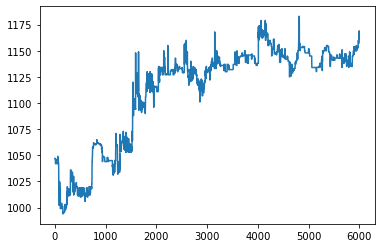

In [206]:
pd.read_csv('data/financial/pump_{coin}_{date}_binance__simplified.csv'.format(coin='evx',date='20211024')).high.plot()